# Quantum SVM

In [100]:
from qiskit import IBMQ
import sklearn.datasets as skd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, EfficientSU2, PauliFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.providers.ibmq import least_busy
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize

In [101]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-08-03 20:44:24,651: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [102]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [195]:
# Create Fake dataset
X, y = make_circles(n_samples=30, shuffle=True, noise=None, random_state=None, factor=0.2)
# X,y = make_classification(n_samples=30, n_features=2, n_informative=2, n_redundant=0, 
#                            n_repeated=0, n_classes=2, random_state=6, class_sep=0.2)
# X,y = make_blobs(n_samples=30, centers=2, n_features=2, random_state=42)
# X,y = skd.make_gaussian_quantiles(mean=None, cov=1.0, n_samples=30, n_features=2, n_classes=2, shuffle=True, random_state=None)
# X,y =skd.make_moons(n_samples=30, shuffle=True, noise=False, random_state=42)


In [196]:
# X = X+4
# Optional change to polar coordinates
# def cart2pol(x, y):
#     rho = np.sqrt(x**2 + y**2)
#     phi = np.arctan2(y, x)
#     return(rho, phi)
# X = [cart2pol(m[0],m[1]) for m in X]
# X=np.array(X)

# X = X+4

In [197]:
#Optional l2 norm
#X = normalize(X,norm='l2')

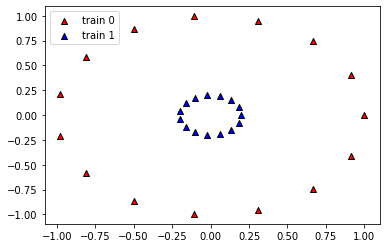

In [198]:
# Data Scatter plot
plt.figure()
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")
plt.legend()
plt.show()

In [199]:
# Qiskit Default dataset
# from qiskit.ml.datasets import ad_hoc_data
# feature_dim = 2
# sample_Total, training_dataset, test_dataset, class_labels = ad_hoc_data(training_size=20, test_size=10,
#                                                                          n=feature_dim, gap=0.3,
#                                                                          plot_data=True)

In [200]:
sample_train, sample_test, label_train, label_test = train_test_split(X, y, test_size=20, 
                                                     train_size=10, shuffle=True, random_state=42)

In [201]:
class_labels = [r'A', r'B']#[r'A', r'B']
training_dataset = {key : np.array(sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
test_dataset = {key : np.array(sample_test[label_test == k, :])[:] for k, key in enumerate(class_labels)}

In [202]:
# Least Busy option
# devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
#                                    and not x.configuration().simulator)
# backend = least_busy(devices)

# backend = provider.get_backend('ibmq_burlington')
random_seed = 10598
feature_dim = 2

In [203]:
# Generate the feature map
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

In [204]:
backend =  BasicAer.get_backend('statevector_simulator')#'statevector_simulator''qasm_simulator'
quantum_instance = QuantumInstance(backend, seed_simulator=random_seed, seed_transpiler=random_seed)

In [205]:
qsvm = QSVM(feature_map = feature_map, training_dataset=training_dataset, test_dataset=test_dataset)

In [206]:
result = qsvm.run(quantum_instance)
# print("testing success ratio: ", result['testing_accuracy'])
print(classification_report(label_test , qsvm.predict(sample_test , quantum_instance)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



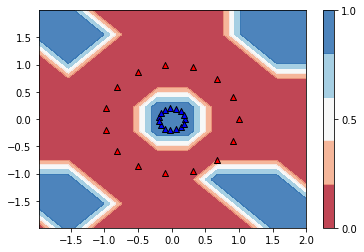

In [207]:
# make data grid for contour plot
x_min, x_max = X[:,0].min() - 1 , X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1 , X[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
# plot decision regions
plt.figure()
cm = plt.cm.RdBu
predictions_grid = qsvm.predict(np.array(X_grid) , quantum_instance)
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.2), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")

plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)
plt.show()

# Classic SVM

In [208]:
from sklearn import svm

In [209]:
clf = svm.SVC(gamma='scale')
clf.fit(sample_train, label_train)

SVC()

In [210]:
print(classification_report(label_test, clf.predict(sample_test) , zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



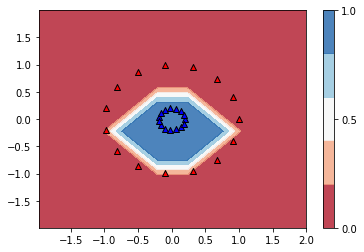

In [211]:
# make data grid for contour plot
x_min, x_max = X[:,0].min() - 1 , X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1 , X[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
# plot decision regions
plt.figure()
cm = plt.cm.RdBu
predictions_grid = clf.predict(np.array(X_grid))
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.2), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")

plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)
plt.show()